# Electricity demand
We explore electricity demand in U.S. states and see if they change in tandem with temperatures. We expect the relationship between temperature and electricity demand to be positively correlated during the summer months and negatively correlated during the winter months. These months will be different for different states. 

At the moment the code takes data in the form of excel sheets from EIA website. We should migrate to using their API at some later time as it gives us greater flexibility.    

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import calendar

In [17]:

# Inputs to the whole code
state = 'VA'    # The state for which we want to do this analysis
consumption_of_interest = 'residential' # Possible values: ('total', 'residential', 'commercial', 'industrial', 'transportation')
start_year = 2016

In [18]:
# Get the data from EIA. EIA has data divided into two sets, with one ranging from 1990 to 2009 and the other from 2010 to now.
# There may be a reason for this split. They may have changed the way data electricity usage is measured or recorded. It is 
# better to not make conclusions assuming that the pre 2009 data is comparable to the post 2009 data. 
raw_df1 = pd.read_excel("https://www.eia.gov/electricity/data/state/xls/861m/HS861M%202010-.xlsx", header=[0,1,2], index_col=[0,1,2,3])
raw_df1.drop(raw_df1.tail(1).index,inplace=True)  # The last row contains stupid footnote
print(raw_df1.head())

raw_df2 = pd.read_excel("https://www.eia.gov/electricity/data/state/xls/861m/HS861M%201990-2009.xlsx", header=[0,1,2], index_col=[0,1,2,3])
raw_df2.drop(raw_df2.tail(1).index,inplace=True)  # The last row contains stupid footnote
print(raw_df2.head())

                           RESIDENTIAL                                      \
                               Revenue         Sales   Customers     Price   
Data Status           Thousand Dollars Megawatthours       Count Cents/kWh   
2024 3 AK Preliminary         47106.50     190614.23    298721.0     24.71   
       AL Preliminary        327401.61    2062746.90   2389928.0     15.87   
       AR Preliminary        155179.26    1205046.60   1476408.0     12.88   
       AZ Preliminary        319355.65    2136693.50   3084292.0     14.95   
       CA Preliminary       1921809.30    5918231.40  14111959.0     32.47   

                            COMMERCIAL                                     \
                               Revenue         Sales  Customers     Price   
Data Status           Thousand Dollars Megawatthours      Count Cents/kWh   
2024 3 AK Preliminary         48420.99     227281.61    57410.0     21.30   
       AL Preliminary        230487.76    1659707.40   383817.0    

In [19]:
# # Debug prints
# print("Temp dataframe indices")
# print(raw_df1.index)
# print("Temp dataframe columns")
# print(raw_df1.columns)
# raw_df1.loc[(2024, 2, 'AK', 'Preliminary'), ('TOTAL', 'Sales', 'Megawatthours')]    # Just make sure we are interpreting the multiindex indices and columns correctly

In [20]:
temp_df1 = raw_df1['TOTAL']['Sales']
temp_df2 = raw_df2['TOTAL']['Sales']

In [21]:
temp_df1.rename(columns={'Megawatthours':'total (MWh)'}, inplace=True)
temp_df1.loc[:,'residential (MWh)'] = raw_df1['RESIDENTIAL']['Sales']['Megawatthours']
temp_df1.loc[:,'commercial (MWh)'] = raw_df1['COMMERCIAL']['Sales']['Megawatthours']
temp_df1.loc[:,'industrial (MWh)'] = raw_df1['INDUSTRIAL']['Sales']['Megawatthours']
temp_df1.loc[:,'transportation (MWh)'] = raw_df1['TRANSPORTATION']['Sales']['Megawatthours']
# print(temp_df1.head())
# print(raw_df1.loc[(2024, 2, 'VA', 'Preliminary'), ('RESIDENTIAL', 'Sales', 'Megawatthours')])
# print(temp_df1.loc[(2024, 2, 'VA', 'Preliminary'), 'residential (MWh)'])

In [22]:
temp_df2.rename(columns={'Megawatthours':'total (MWh)'}, inplace=True)
temp_df2.loc[:,'residential (MWh)'] = raw_df2['RESIDENTIAL']['Sales']['Megawatthours']
temp_df2.loc[:,'commercial (MWh)'] = raw_df2['COMMERCIAL']['Sales']['Megawatthours']
temp_df2.loc[:,'industrial (MWh)'] = raw_df2['INDUSTRIAL']['Sales']['Megawatthours']
temp_df2.loc[:,'transportation (MWh)'] = raw_df2['TRANSPORTATION']['Sales']['Megawatthours']
# print(temp_df2.head())
# print(raw_df2.loc[(2007, 2, 'VA', 'Final'), ('RESIDENTIAL', 'Sales', 'Megawatthours')])
# print(temp_df2.loc[(2007, 2, 'VA', 'Final'), 'residential (MWh)'])

In [23]:
combined_temp_df = pd.concat([temp_df1, temp_df2])
# print(combined_temp_df.head())
# print(combined_temp_df.tail())

In [24]:
sales = combined_temp_df.rename_axis(['year','month', 'state','Data Status']).reset_index()
sales.rename_axis(None, axis=1, inplace=True)
sales = sales[(sales['Data Status'] == 'Final')]
# print(sales.head())
# print(sales.tail())

In [25]:
# Format date and drop useless columns
sales.loc[:,'temp col'] = sales['month'].map(str)+ '-' +sales['year'].map(str)     # Without using loc, you get warnings
sales.loc[:,'date'] = pd.to_datetime(sales['temp col'], format='%m-%Y')
sales.drop(columns=['year', 'month', 'Data Status', 'temp col'], inplace=True)
sales.sort_values(by=['date'], ascending=True, inplace=True)
print(sales.head())

      state  total (MWh)  residential (MWh) commercial (MWh) industrial (MWh)  \
20960    WY    1056455.0           195508.0           192662           653016   
20931    ME    1095864.0           440117.0           248913           391657   
20930    MD    5024470.0          2333681.0           966266          1662862   
20929    MA    4421928.0          1767550.0          1698605           840363   
20928    LA    5137775.0          1808037.0          1085651          1987988   

      transportation (MWh)       date  
20960                    . 1990-01-01  
20931                    . 1990-01-01  
20930                    . 1990-01-01  
20929                    . 1990-01-01  
20928                    . 1990-01-01  


Start year: 1990
End year: 2022


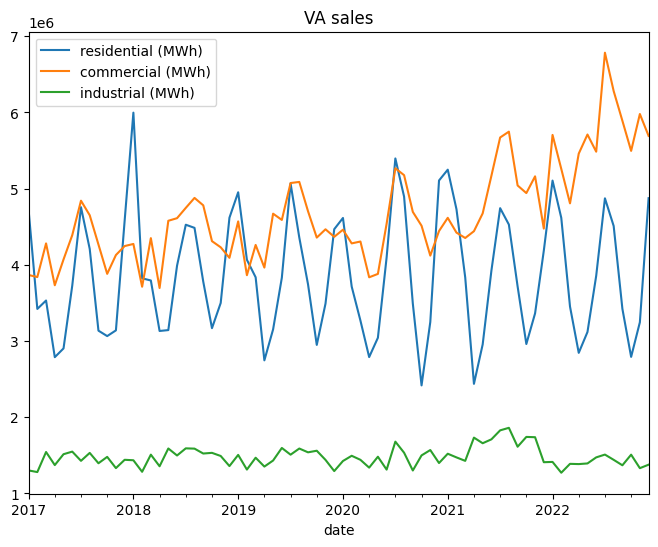

In [35]:
# Visualize sales for a state
state_sales = sales[sales.state == state]
if state_sales.index.size%12 != 0:
    print("MAJOR ISSUE: We need to have 12 full months of data for each year in the state sales. Otherwise FFT down the line will fail. STOP EXECUTION")

data_start_year = np.min(state_sales['date'].dt.year.values)
data_end_year = np.max(state_sales['date'].dt.year.values)
total_years = data_end_year - data_start_year     # This will be useful later
print("Start year: " + str(data_start_year))
print("End year: " + str(data_end_year))
state_sales.set_index('date', inplace=True)
ax = state_sales[state_sales.index.year>start_year].plot(y=['residential (MWh)',\
                                                            'commercial (MWh)',\
                                                            'industrial (MWh)'],\
                                                            title = state+" sales", figsize=(8,6))

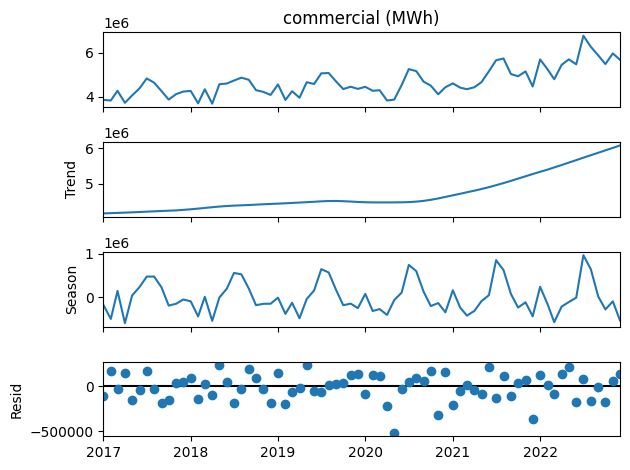

In [37]:
from statsmodels.tsa.seasonal import STL
stl = STL(state_sales[state_sales.index.year>start_year]['commercial (MWh)'], seasonal=13)
res = stl.fit()
fig = res.plot()

In [27]:
# # Get the temperature data (from NCEI - NOAA - https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series)
# temp_raw = pd.read_csv("C:/Users/dinesh/OneDrive - Fordham University/Planette/Code/texas_temp_1990_2022.csv")
# temp_raw.loc[:,'date'] = pd.to_datetime(temp_raw['Date'], format='%Y%m')    # Massage the dates to make them usable in this code
# temp_raw.drop(columns=['Date'], inplace=True)
# temp_raw.set_index('date', inplace=True)

# # Merge temperature into state_sales data
# state_sales.loc[:,'temperature'] = temp_raw.loc[:,'Value']
# state_sales.loc[:,'consumption (MWh)'] = signal.detrend(state_sales.loc[:,col_of_interest]) # We use a detrended version of consumption type we are interested in 
# print(temp_raw.head())
# print(state_sales.head())